In [40]:
import pandas as pd
import numpy as np

In [2]:
import os
os.chdir('data')

In [94]:
import importlib
import helpers
importlib.reload(helpers)
from helpers import get_lagged_main_df, get_forecast, get_period
from helpers import r2_score_adj, mean_absolute_percentage_error
from helpers import Naive

In [8]:
import matplotlib.pyplot as plt 

In [9]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, ElasticNetCV
from sklearn.svm import SVR

In [262]:
from datetime import datetime, timedelta, date, time
from dateutil.relativedelta import relativedelta

# Load data

In [78]:
final_w_df = pd.read_csv('final_w_df.tsv', sep='\t')
final_w_df.set_index('period', inplace=True)
final_w_df.index = final_w_df.index.astype('datetime64[ns]', copy=False)

In [79]:
main_w_df = get_lagged_main_df(final_w_df, n_lag_target=12, n_lag_feature=12)

In [80]:
main_w_df = main_w_df.dropna()

In [81]:
list(final_w_df.columns)

['target',
 'Brent Crude Oil Price',
 'Natural Gas Spot Price, TTF NW Europe',
 'Handysize 28K DWT 15 Year Old Secondhand Prices',
 'Handysize 28k dwt 20 Year Old Secondhand Prices',
 'Handysize 37k dwt 5 Year Old Secondhand Prices',
 'Handysize 32K 10 Year Old Secondhand Prices',
 'Handysize 38k dwt Resale Secondhand Prices',
 'India Scrap Price (Handymax/Handysize Bulkcarrier)',
 'Bangladesh Scrap Price (Handymax/Handysize Bulkcarrier)',
 'US Interest Rate: Prime',
 'Japan Interest Rate: Short Term Prime',
 'UK Interest Rate: Official Bank Rate',
 'Switzerland Interest Rate: Policy Rate',
 'Market Interest Rate: US$ LIBOR 6 Months',
 '38-40K DWT Handysize Bulkcarrier Newbuilding Prices',
 '25-30K DWT Handysize Bulkcarrier Newbuilding Prices']

# Select features

In [82]:
main_w_df.shape

(657, 239)

In [329]:
from mlxtend.feature_selection import SequentialFeatureSelector
finish_date = '2022-06-24'
start_data = '2009-11-27'
split_start = 579 #2021-01-01
look_forward = 8
df = main_w_df[((main_w_df.index >= start_data) & ((main_w_df.index <= finish_date)))]
X = df.drop(['target'], axis=1)
y = df.target

splits = [(np.array(range(0, i)), 
           np.array(range(i, i + look_forward))) for i in range(split_start, 
                                                                X.shape[0] - (look_forward - 1), look_forward - 1)]

scaler = StandardScaler()
scaler.fit(X)

sfs = SequentialFeatureSelector(
                                estimator=ElasticNet(),
                                #estimator=LinearRegression(),
                                forward=True,
                                k_features=(5, 30), 
                                cv=splits,
                                #scoring=r2_score_adj
                                scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)
                               )
if scaler:
    sfs.fit(scaler.transform(X), y)
else:
    sfs.fit(X, y)
selected_cols_sfs = list(X.columns[list(sfs.k_feature_idx_)])
len(selected_cols_sfs)

30

In [294]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[0.8436380210180576, -0.3314326615462926, -1.5...",-0.035923,"(0,)",1.092763,0.850207,0.425103
2,"(0, 1)","[0.9283185828584954, 0.4678535766560292, 0.023...",0.553736,"(0, 1)",0.404771,0.314926,0.157463
3,"(0, 1, 12)","[0.9337804049596944, 0.6640832420971348, 0.465...",0.713021,"(0, 1, 12)",0.204355,0.158995,0.079498
4,"(0, 1, 2, 12)","[0.9367605335186723, 0.7445622590609478, 0.623...",0.776288,"(0, 1, 2, 12)",0.131787,0.102535,0.051267
5,"(0, 1, 2, 3, 12)","[0.9316930190753362, 0.7751305718246064, 0.693...",0.800284,"(0, 1, 2, 3, 12)",0.098383,0.076546,0.038273
6,"(0, 1, 2, 3, 4, 12)","[0.9232303250708562, 0.7864158213848985, 0.726...",0.80793,"(0, 1, 2, 3, 4, 12)",0.083797,0.065197,0.032599
7,"(0, 1, 2, 3, 4, 9, 12)","[0.9092702693508423, 0.7888923016957606, 0.745...",0.809378,"(0, 1, 2, 3, 4, 9, 12)",0.073487,0.057175,0.028588
8,"(0, 1, 2, 3, 4, 9, 12, 27)","[0.9082425653530763, 0.7876370294608368, 0.748...",0.809188,"(0, 1, 2, 3, 4, 9, 12, 27)",0.07187,0.055917,0.027959
9,"(0, 1, 2, 3, 4, 9, 12, 27, 209)","[0.9075453455622223, 0.785897529133173, 0.7472...",0.80824,"(0, 1, 2, 3, 4, 9, 12, 27, 209)",0.072247,0.056211,0.028105
10,"(0, 1, 2, 3, 4, 9, 12, 27, 168, 209)","[0.9069795507877333, 0.818927971460865, 0.7100...",0.809554,"(0, 1, 2, 3, 4, 9, 12, 27, 168, 209)",0.08143,0.063355,0.031678


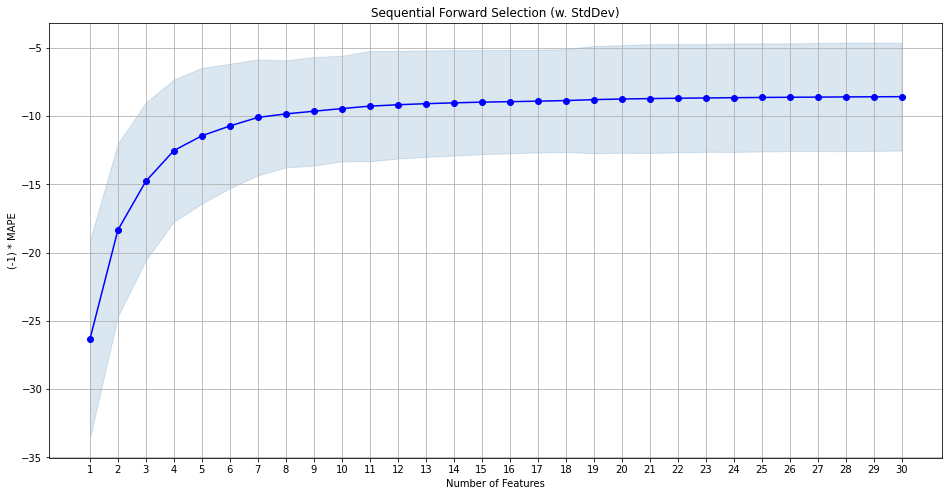

In [333]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), ylabel='(-1) * MAPE', figsize=(16,8))
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [334]:
filtered_df = main_w_df[['target'] + selected_cols_sfs]
train_df = filtered_df.copy()
train_df = train_df[((train_df.index >= '2009-11-27') & ((train_df.index <= finish_date)))]

X = train_df.drop(['target'], axis=1)
y = train_df.target

scaler = StandardScaler()
scaler.fit(X)
#scaler = None

StandardScaler()

In [335]:
if not scaler:
    scores = cross_val_score(ElasticNet(), X, y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
else:
    scores = cross_val_score(ElasticNet(), scaler.transform(X), 
                             y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
scores, np.mean(scores)

(array([ 7.94048287, 13.620866  ,  9.03191154, 12.56304515, 12.51569662,
         9.02122828, 11.41821924,  2.98784953, 10.10733066,  2.82384017,
         2.31458642]),
 8.576823317271241)

In [336]:
scores = cross_val_score(Naive(), X, y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
scores, np.mean(scores)

(array([3.1250016 , 6.96702282, 3.13791377, 2.19128747, 2.2222588 ,
        1.24983009, 6.41537419, 2.80809753, 4.19896036, 2.94501185,
        1.83562555]),
 3.3723985492515514)

In [337]:
X_train = X.iloc[splits[-1][0]]
y_train = y.iloc[splits[-1][0]]

X_val = X.iloc[splits[-1][1]]
y_val = y.iloc[splits[-1][1]]

In [338]:
model = ElasticNet()
if not scaler:
    model.fit(X_train, y_train)
    forecast = model.predict(X_val)
else:
    model.fit(scaler.transform(X_train), y_train)
    forecast = model.predict(scaler.transform(X_val))

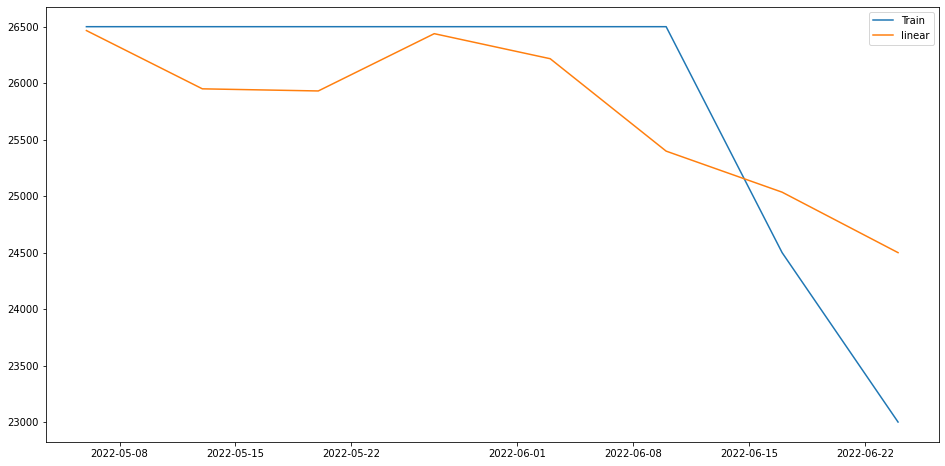

In [339]:
t = pd.DataFrame(y_val)
t['prediction'] = forecast
plt.figure(figsize=(16,8))
plt.plot(t.target, label='Train')
plt.plot(t.prediction, label='linear')
plt.legend(loc='best')
plt.show()

In [340]:
n_lag_target = 12
n_step = look_forward

forecasts = []
date_points = []
date_point_start = date(2022, 2, 11)
for i in range(0, 20):
    s_date = date_point_start + relativedelta(days=7*(i + 1))
    f_date = date_point_start + relativedelta(days=7*(i + n_step))
    forecast_df = pd.DataFrame(data={'period': 
                               get_period(start_date=s_date, 
                                          finish_date=f_date, period='w')})
    forecasts.append(forecast_df)
    date_points.append(date_point_start + relativedelta(days=7*i))
    
for i, date_point in enumerate(date_points):
    train_period_df = main_w_df[((main_w_df.index >= start_data) & ((main_w_df.index <= str(date_point))))]
    X_train = train_period_df.drop(['target'], axis=1)[selected_cols_sfs]
    y_train = train_period_df.target
    model = ElasticNet()
    if not scaler:
        model.fit(X_train, y_train)
    else:
        model.fit(scaler.transform(X_train), y_train)

    forecast_df = forecasts[i]
    forecast_df.set_index('period', inplace=True)
    forecast_df['pred'] = get_forecast(main_w_df.loc[str(date_point):str(date_point)], 
                                       model, selected_cols_sfs, 
                                       n_step=n_step, n_lag=n_lag_target, scaler=scaler)[0]
    

In [283]:
mean_absolute_percentage_error(main_w_df.target[-look_forward:].values, forecasts[0].pred.values)

4.220221577342987

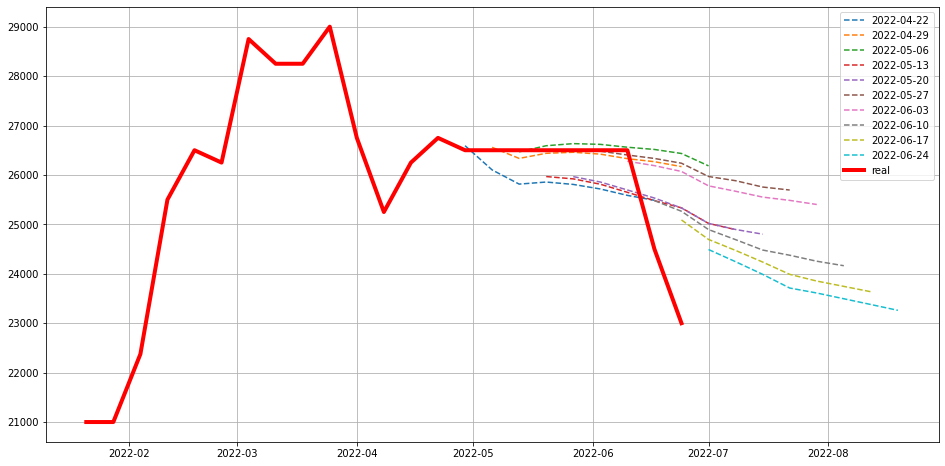

In [343]:
plt.figure(figsize=(16,8))
for i, date_point_str in enumerate(date_points[10:]):
    plt.plot(forecasts[i+10], label=date_point_str, linestyle='--')

#plt.plot(forecast_m, label='forecast',
#         color='black', linestyle='-',
#         linewidth=4)
plt.plot(main_w_df[(main_w_df.index >= '2022-01-18')].target, label='real',
         color='red',
         linewidth=4)
plt.legend(loc='best')
plt.grid()
plt.show()

In [344]:
finish_date = date(2022, 6, 24)
filtered_df = main_w_df[['target'] + selected_cols_sfs]
train_df = filtered_df.copy()
train_df = train_df[((train_df.index >= start_data) & ((train_df.index <= str(finish_date))))]

X = train_df.drop(['target'], axis=1)
y = train_df.target

In [345]:
mean_absolute_percentage_error(y, X.target_lag_1), r2_score(y, X.target_lag_1)

(1.6769696296949885, 0.9917625945768374)

In [346]:
model = ElasticNet()
if not scaler:
    model.fit(X, y)
else:
    model.fit(scaler.transform(X), y)

In [347]:
if not scaler:
    forecast = model.predict(X)
else:
    forecast = model.predict(scaler.transform(X))
train_df['prediction'] = forecast
mean_absolute_percentage_error(y, forecast), r2_score(y, forecast)

(6.370260577613504, 0.9649927066116493)

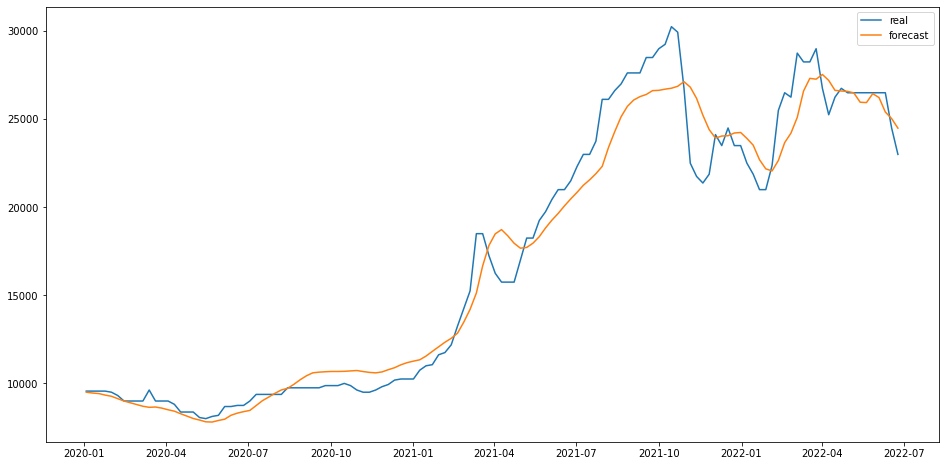

In [348]:
plt.figure(figsize=(16,8))
plt.plot(train_df[((train_df.index >= '2020-01-01') & ((train_df.index <= '2022-06-24')))].target, label='real')
plt.plot(train_df[((train_df.index >= '2020-01-01') & ((train_df.index <= '2022-06-24')))].prediction, label='forecast')
plt.legend(loc='best')
plt.show()

In [349]:
# get importance
feature_importances = abs(model.coef_)
# summarize feature importance
feature_names = X.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True)[:300]:
    print('{}: {}'.format(name, score))

target_lag_1: 814.1569960855712
target_lag_2: 733.5236762192291
target_lag_3: 668.372032257657
target_lag_mean: 628.3519024580487
target_lag_4: 617.8758988896526
target_lag_std: 275.7648573981231
Handysize 32K 10 Year Old Secondhand Prices_lag_std: 180.53481368527332
Natural Gas Spot Price, TTF NW Europe_lag_8: 178.05717054103704
38-40K DWT Handysize Bulkcarrier Newbuilding Prices_lag_std: 168.1545440513516
Natural Gas Spot Price, TTF NW Europe_lag_12: 162.3404465402909
India Scrap Price (Handymax/Handysize Bulkcarrier)_lag_1: 133.98313505956304
India Scrap Price (Handymax/Handysize Bulkcarrier)_lag_2: 115.30384145545628
India Scrap Price (Handymax/Handysize Bulkcarrier)_lag_3: 100.05880660339577
Brent Crude Oil Price_lag_12: 92.96494769867161
Bangladesh Scrap Price (Handymax/Handysize Bulkcarrier)_lag_1: 84.79019539440208
Japan Interest Rate: Short Term Prime_lag_mean: 79.50206824454254
Brent Crude Oil Price_lag_11: 78.36250354036473
Bangladesh Scrap Price (Handymax/Handysize Bulkcarr

# LSTM

# Boosting

In [113]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv, EFeaturesSelectionAlgorithm, EShapCalcType

In [129]:
from mlxtend.feature_selection import SequentialFeatureSelector
finish_date = '2022-06-24'
split_start = 579 #2021-01-01

df = main_w_df[((main_w_df.index >= '2009-11-27') & ((main_w_df.index <= finish_date)))]
X = df.drop(['target'], axis=1)
y = df.target

splits = [(np.array(range(0, i)), 
           np.array(range(i, i + 24))) for i in range(split_start, X.shape[0] - 23, 23)]

In [130]:
X_train = X.iloc[splits[-1][0]]
y_train = y.iloc[splits[-1][0]]

X_val = X.iloc[splits[-1][1]]
y_val = y.iloc[splits[-1][1]]

train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

In [132]:
model_select = CatBoostRegressor(thread_count=8,
                                 iterations=1000,
                                 #l2_leaf_reg = 2.0, 
                                 #learning_rate = 0.01,
                                 loss_function='MAPE',
                                 od_type='Iter',
                                 od_wait=10)
res = model_select.select_features(
    train_pool,
    eval_set=val_pool,
    features_for_select=list(range(0, X_train.shape[1], 1)),
    num_features_to_select=50,
    steps=5,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    verbose=False,
    logging_level=None,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 5
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.1667716936
bestIteration = 477

Shrink model to first 478 iterations.
Feature #66 eliminated
Feature #48 eliminated
Feature #75 eliminated
Feature #59 eliminated
Feature #61 eliminated
Feature #80 eliminated
Feature #19 eliminated
Feature #91 eliminated
Feature #199 eliminated
Feature #77 eliminated
Feature #83 eliminated
Feature #118 eliminated
Feature #172 eliminated
Feature #20 eliminated
Feature #106 eliminated
Feature #142 eliminated
Feature #171 eliminated
Feature #64 eliminated
Feature #183 eliminated
Feature #57 eliminated
Feature #197 eliminated
Feature #114 eliminated
Feature #196 eliminated
Feature #135 eliminated
Feature #92 eliminated
Feature #21 eliminated
Feature #185 eliminated
Feature #17 eliminated
Feature #63 eliminated
Feature #52 eliminated
Feature #237 eliminated
Feature #89 eliminated
Feature #27 eliminated
Feature #26 eliminated
Feature #200 eliminated
Feature #167 eliminated
Fe

In [133]:
best_iter = 473
selected_features = list(X_train.columns[res['selected_features']])

In [134]:
scores = cross_val_score(CatBoostRegressor(thread_count=8,
                                           iterations=best_iter,
                                           #l2_leaf_reg = 2.0, 
                                           #learning_rate = 0.05,
                                           od_type='Iter',
                                           od_wait=10,
                                           loss_function='MAPE',
                                           #use_best_model=True,
                                           verbose=False), 
                          X[selected_features], y, cv=splits, scoring=make_scorer(mean_absolute_percentage_error))
scores, np.mean(scores)

(array([27.89784625, 30.67076262, 13.78361818]), 24.117409015165475)